In [2]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import pickle
import csv
import random
import regex

### FileReader

In [3]:
import pickle
import pandas as pd
def readPkl(file):
    with open(file, "rb") as f:
        data = pickle.load(f)
    return data

def readCsv(file):
    data = pd.read_csv(file)
    return data

def readGeneratedRegex(file) -> list:
    data = pd.read_csv(file, usecols=[0],header=None,encoding='ISO-8859-1')
    return data.iloc[:, 0].tolist()
    


### FileProcessor

In [45]:
import pandas as pd
import csv
import random
import numpy as np
def get_unique_sids_list(df):
    unique_sids = df[df['text'].notnull()]['sid'].unique()
    return unique_sids

def map_sid_to_unique_texts(df):
    sid_to_texts = {}
    for _, row in df.iterrows():
        sid = row['sid']
        text = row['text']
        if pd.notnull(text):  # 確保 text 不是 NaN
            if sid in sid_to_texts:
                sid_to_texts[sid].add(text)
            else:
                sid_to_texts[sid] = {text}
    return sid_to_texts


def merge_dataframes_to_dict(dfs):
    """
    Merge multiple dataframes into a dictionary where each sid maps to a list of unique texts.

    :param dfs: List of pandas DataFrames, each with columns 'sid' and 'text'
    :return: Dictionary with sid as keys and list of unique texts as values
    """
    merged_dict = {}

    for df in dfs:
        for _, row in df.iterrows():
            sid = row['sid']
            text = row['text']
            if pd.notnull(text):  # Ensure text is not NaN
                if sid not in merged_dict:
                    merged_dict[sid] = set()  # Use a set to avoid duplicates
                merged_dict[sid].add(text)

    # Convert sets to lists
    merged_dict = {sid: list(texts) for sid, texts in merged_dict.items()}
    
    return merged_dict

def filter_sids_by_text_length(sid_to_texts_dict):
    filtered_sid_to_texts_dict = set()
    for key, value in sid_to_texts_dict.items():
        if len(value) > 5:  # 確保字串長度超過 5
            filtered_sid_to_texts_dict.add(key)
    return filtered_sid_to_texts_dict

def get_sorted_filtered_sids(sid_to_texts_dict):
    filtered_sids = filter_sids_by_text_length(sid_to_texts_dict)
    sorted_filtered_sids = sorted(filtered_sids)
    return sorted_filtered_sids


def select_random_texts(sid_to_texts_dict, exclude_sid, num_texts=100):
    # 過濾掉給定的 SID
    filtered_texts = [texts for sid, texts in sid_to_texts_dict.items() if sid != exclude_sid]
    
    # 將多個列表平坦化為單一列表
    all_texts = [text for sublist in filtered_texts for text in sublist]
    
    # 過濾掉 nan 值
    all_texts = [text for text in all_texts if not (isinstance(text, float) and np.isnan(text))]
    
    # 隨機選擇 100 個文本，若總數少於 100 則選擇所有文本
    selected_texts = random.sample(all_texts, min(len(all_texts), num_texts))
    
    return selected_texts

def select_all_negative_texts(sid_to_texts_dict, exclude_sid, num_texts=100):
    # 過濾掉給定的 SID
    filtered_texts = [texts for sid, texts in sid_to_texts_dict.items() if sid != exclude_sid]
    
    # 將多個列表平坦化為單一列表
    all_texts = [text for sublist in filtered_texts for text in sublist]
    
    # 過濾掉 nan 值
    all_texts = [text for text in all_texts if not (isinstance(text, float) and np.isnan(text))]
    
    return all_texts
def prompt_generator(dfs):
    sid_to_unique_texts_dict = merge_dataframes_to_dict(dfs)
    sorted_filtered_sids = get_sorted_filtered_sids(sid_to_unique_texts_dict)
    for sid in sorted_filtered_sids:
        with open(f'prompt/{sid}_prompt.txt', 'a') as file:
            texts = list(sid_to_unique_texts_dict[sid])
            random.shuffle(texts)
            selected_texts = texts[:50]
            file.write(f"sid: {sid}, text: {selected_texts}\n")
            file.write("\n")
            file.write("Please find a regular expression to match all packet payloads.\n" + 
                        "You need to find the similarities in the sentences and generalize the parts where they differ. \n" + 
                        "The regular expression is in PCRE format, please be aware to evaluate the validity of the expression you generated under PCRE regulations. \n" + 
                        "There will be examples to help you find the patterns. \n"  +
                        "[‘DELE 3\\r\\n’, ‘DELE 128\\r\\n’, ‘DELE 74\\r\\n’, ‘DELE 22\\r\\n’, ‘DELE 70\\r\\n’] \n" +
                        "These examples show the attacker is trying to delete someone’s email by POP protocol. \n" +
                        "The index of the desired mail is indicated under the DELE command. \n" +
                        "Thus the best regular expression that matches them will be ‘^(DELE)( )(.*)(\\r\\n)$’ \n" + "\n" +
                        "With the given example payloads: \n" +
                        "[‘EHLO BtuCBHdSb51.com\\r\\n’, ‘EHLO 203.187.87.27\\r\\n’, ‘EHLO slae02Fo9Ep.com\\r\\n’, ‘EHLO 210.64.37.51\\r\\n’, ‘EHLO LLb0RwqdbkikFWo.com\\r\\n’] \n" + 
                        "These examples show the attacker is trying to make sure the SMTP server is up and running. " + 
                        "The command EHLO works in both lower case and uppercase, after that follows the SMTP server address. \n" +
                        "Thus the best regular expression to match them will be ‘^([E|e][H|h][L|l][O|o])(.*)(\\r\\n)$’ \n" + "\n" +
                        "Next, with the given payloads: \n")
            file.write(f"{selected_texts}\n")         
            file.write("Please give 3 possible and different regular expressions to match all of the elements. \n" +
                        "You can give only 1 expression if the 3 expressions you find are too similar. \n" + 
                        "Let’s work this out in a step-by-step way to make sure we have the right answer. \n" + 
                        "To make the expression not too general, make sure the expressions don’t match these negative examples: [‘CAPA\\r\\n’, ‘CAPA\\r\\n’, ‘\\x15\\x03\\x01’, ‘GET / HTTP/1.0\\r\\n\\r\\n’, ‘r\\n\\r\\n’] \n" +
                        "You only need to give me the three regular expressions in code format.\n")
            file.write("\n")

def prompt_generator_old(pop_df, imap_df, smtp_df, sip_df):
    protocols = [
    {'name': 'pop_df', 'data': pop_df},
    {'name': 'imap_df', 'data': imap_df},
    {'name': 'smtp_df', 'data': smtp_df},
    {'name': 'sip_df', 'data': sip_df}
    ]

    with open('prompt.txt', 'w') as file:
        pass

    with open('prompt.txt', 'a') as file:
        for protocol in protocols:
            protocol_name = protocol['name']
            protocol_data = protocol['data']
            
            sid_to_unique_texts = map_sid_to_unique_texts(protocol_data)
            filtered_sids = filter_sids_by_text_length(sid_to_unique_texts)
            
            # Sort the filtered_sids to ensure the output is ordered by SID
            sorted_filtered_sids = sorted(filtered_sids)
            
            file.write(f"Protocol: {protocol_name}\n")
            
            for sid in sorted_filtered_sids:
                texts = list(sid_to_unique_texts[sid])
                random.shuffle(texts)
                selected_texts = texts[:50]
                file.write(f"sid: {sid}, text: {selected_texts}\n")
                file.write("\n")
                file.write("Please find a regular expression to match all packet payloads.\n" + 
                            "You need to find the similarities in the sentences and generalize the parts where they differ. \n" + 
                            "The regular expression is in PCRE format, please be aware to evaluate the validity of the expression you generated under PCRE regulations. \n" + 
                            "There will be examples to help you find the patterns. \n"  +
                            "[‘DELE 3\\r\\n’, ‘DELE 128\\r\\n’, ‘DELE 74\\r\\n’, ‘DELE 22\\r\\n’, ‘DELE 70\\r\\n’] \n" +
                            "These examples show the attacker is trying to delete someone’s email by POP protocol. \n" +
                            "The index of the desired mail is indicated under the DELE command. \n" +
                            "Thus the best regular expression that matches them will be ‘^(DELE)( )(.*)(\\r\\n)$’ \n" + "\n" +
                            "With the given example payloads: \n" +
                            "[‘EHLO BtuCBHdSb51.com\\r\\n’, ‘EHLO 203.187.87.27\\r\\n’, ‘EHLO slae02Fo9Ep.com\\r\\n’, ‘EHLO 210.64.37.51\\r\\n’, ‘EHLO LLb0RwqdbkikFWo.com\\r\\n’] \n" + 
                            "These examples show the attacker is trying to make sure the SMTP server is up and running. " + 
                            "The command EHLO works in both lower case and uppercase, after that follows the SMTP server address. \n" +
                            "Thus the best regular expression to match them will be ‘^([E|e][H|h][L|l][O|o])(.*)(\\r\\n)$’ \n" + "\n" +
                            "Next, with the given payloads: \n")
                file.write(f"{selected_texts}\n")         
                file.write("Please give 3 possible and different regular expressions to match all of the elements. \n" +
                            "You can give only 1 expression if the 3 expressions you find are too similar. \n" + 
                            "Let’s work this out in a step-by-step way to make sure we have the right answer. \n" + 
                            "To make the expression not too general, make sure the expressions don’t match these negative examples: [‘CAPA\\r\\n’, ‘CAPA\\r\\n’, ‘\\x15\\x03\\x01’, ‘GET / HTTP/1.0\\r\\n\\r\\n’, ‘r\\n\\r\\n’] \n" +
                            "You only need to give me the three regular expressions in code format.\n")
                file.write("\n")
            file.write("\n")

def getGroupedSidtoRegexDict(generated_regex_list, number_of_regexes, sid_to_unique_texts):
    sorted_sid_list = get_sorted_filtered_sids(sid_to_unique_texts)
    sid_to_regex_dict = {}  # Dictionary to store SID to regex list mapping
    regex_index = 0  # Index to keep track of the current position in generated_regex_list

    for sid in sorted_sid_list:
        # Extract number_of_regexes elements for each SID, including NaN
        regex_sublist = generated_regex_list[regex_index:regex_index+number_of_regexes]
        # Filter out NaN values from the sublist
        filtered_sublist = [regex for regex in regex_sublist if pd.notnull(regex)]
        sid_to_regex_dict[sid] = filtered_sublist
        regex_index += number_of_regexes  # Move the index

    return sid_to_regex_dict


### RegexEvaluator

In [38]:
import csv
import random
import pandas as pd
import regex
from API.FileProcessor import select_random_texts, map_sid_to_unique_texts

def getPcreAnsBySid(sid):
    with open('sid_table(packet).csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['SID'] == str(sid):
                # Remove leading and trailing slashes from the pcre value
                return row['pcre']
    return None

def match_patterns(targetText, generatedPatternList,isPositive=True):
    non_matching_patterns = []  # Step 1: Initialize list for non-matching patterns
    # Check each pattern and add non-matching ones to the list
    for i, pattern in enumerate(generatedPatternList):
        # 确保 pattern 是字符串类型
        if not isinstance(pattern, str):
            raise TypeError(f"Pattern at index {i} is not a string: {pattern} (type {type(pattern)})")
        # 确保 targetText 是字符串类型
        if not isinstance(targetText, str):
            raise TypeError(f"targetText is not a string: {targetText} (type {type(targetText)})")
        if not regex.search(pattern, targetText, regex.DOTALL):
            non_matching_patterns.append(f"Pattern {i+1}: {pattern}")
    ourResult = True if (len(generatedPatternList)-len(non_matching_patterns))/len(generatedPatternList) >= 2/3 else False
    #ansMatch = bool(regex.search(ansPattern, targetText))
    return ourResult == isPositive

def positive_answer_evaluation(threeAnsPattern,sid,df):
    correct = 0
    total = 0
    errorList = []
    ansPattern = getPcreAnsBySid(str(sid))
    print(f"ansPattern: {ansPattern}")
    sid_to_unique_texts = map_sid_to_unique_texts(df)
    texts = sid_to_unique_texts[sid]
    for text in texts:
        total = total + 1
        correct = correct + bool(regex.search(ansPattern, text, regex.DOTALL))
        if not match_patterns(text, threeAnsPattern, True):
            errorList.append(text)

    print("positive test")
    print(f"correct: {correct}, total: {total}")
    print(f"errorList: {errorList}")
    return correct, total
def negative_answer_evaluation(GeneratedPatternList,sid,sid_to_unique_texts_dict):
    correct = 0
    total = 0
    errorList = []
    ansPattern = getPcreAnsBySid(str(sid))
    texts = select_random_texts(sid_to_unique_texts_dict, sid)
    for text in texts:
        # 确保 ansPattern 是字符串类型
        if not isinstance(ansPattern, str):
            raise TypeError(f"ansPattern is not a string: {ansPattern} (type {type(ansPattern)})")
        # 确保 text 是字符串类型
        if not isinstance(text, str):
            raise TypeError(f"text is not a string: {text} (type {type(text)})")
        total = total + 1
        if(not regex.search(ansPattern, text, regex.DOTALL)):
            correct = correct + 1
        if  not match_patterns(text, GeneratedPatternList, False):
            errorList.append(text)
    print("negative test")
    print(f"correct: {correct}, total: {total}")
    for error_text in errorList:
        print(error_text)
    print(f"errorList: {errorList}")
    
def positive_evaluation(generatedPattern,sid,sid_to_unique_texts_dict, file, positive_sid_to_success_rate_dict):
    correct = 0
    total = 0
    errorList = []
    #ansPattern = getPcreAnsBySid(str(sid))
    #print(f"ansPattern: {ansPattern}")
    texts = sid_to_unique_texts_dict[sid]
    for text in texts:
        # 确保 text 是字符串类型
        if not isinstance(text, str):
            raise TypeError(f"text is not a string: {text} (type {type(text)})")
        total = total + 1
        correct = correct + match_patterns(text, generatedPattern, True)
        if not match_patterns(text, generatedPattern, True):
            errorList.append(text)
    
    positive_sid_to_success_rate_dict[sid] = correct/total
    #print("positive test")
    #print(f"correct: {correct}, total: {total}")
    file.write('positive test\n')
    file.write(f"correct: {correct}, total: {total}, correct rate:{100*(correct/total)}%\n")
    for error in errorList:
        file.write(f"errorList: {error}")
        file.write('\n')
    return correct, total

def negative_evaluation(GeneratedPatternList,sid,sid_to_unique_texts_dict, NEGATIVE_SAMPLE_NUMBER,file, negative_sid_to_success_rate_dict):
    correct = 0
    total = 0
    errorList = []
    #ansPattern = getPcreAnsBySid(str(sid))
    texts = select_all_negative_texts(sid_to_unique_texts_dict, sid,NEGATIVE_SAMPLE_NUMBER)
    
    
    for text in texts:
        total = total + 1
        correct = correct + match_patterns(text, GeneratedPatternList, False)
        if  not match_patterns(text, GeneratedPatternList, False):
            errorList.append(text)
    #print("negative test")
    #print(f"correct: {correct}, total: {total}")
    negative_sid_to_success_rate_dict[sid] = correct/total
    file.write('negative test\n')
    file.write(f"correct: {correct}, total: {total}, correct rate:{100*(correct/total)}%\n")
    for error in errorList:
        file.write(f"errorList: {error}")
        file.write('\n')
    




### Main

In [6]:
pop_df = readPkl("data/pop_report_with_tknscore_new.pkl")
imap_df = readPkl("data/imap_report_with_tknscore_new.pkl")
smtp_df = readPkl("data/smtp_report_with_tknscore_new.pkl")
sip_df = readPkl("data/sip_report_with_tknscore_new.pkl")
label_df = readCsv("data/sid_table(packet).csv")
generatedRegex: list = readGeneratedRegex("data/generated regex.csv")

In [7]:
generatedRegex: list = readGeneratedRegex("data/generated regex.csv")
generatedRegex

['^DELE \\d+\\r\\n$',
 '^DELE [0-9]+\\r\\n$',
 '^DELE [1-9][0-9]*\\r\\n$',
 '^(DELE \\d+\\r\\n)$',
 '^(DELE [1-9]\\d*\\r\\n)$',
 '^(DELE (?:[1-9]\\d{0,2}|1[0-2]\\d{2})\\r\\n)$',
 '^DELE [0-9]{1,3}\\r\\n$',
 '^DELE \\d{1,3}\\r\\n$',
 '^DELE [1-9][0-9]{0,2}\\r\\n$',
 '^(RETR \\d+\\r\\n|TOP \\d+ 0\\r\\n)$',
 '^(RETR [0-9]+\\r\\n|TOP [0-9]+ 0\\r\\n)$',
 '^(RETR \\d{1,3}\\r\\n|TOP \\d{1,3} 0\\r\\n)$',
 '^(TOP|RETR) [0-9]+( 0)?\\r\\n$',
 '^(TOP [0-9]+ 0\\r\\n|RETR [0-9]+\\r\\n)$',
 '^(TOP|RETR) [0-9]{1,3}( 0)?\\r\\n$',
 '^(RETR|TOP) \\d+( 0)?\\r\\n$',
 '^(RETR \\d+\\r\\n|TOP \\d+ 0\\r\\n)$',
 '^TOP \\d+ 0\\r\\n|RETR \\d+\\r\\n$',
 '^GET http://clientapi\\.ipip\\.net/echo\\.php\\?info=\\d{14} HTTP/1\\.1\\\\r\\\\nHost: clientapi\\.ipip\\.net\\\\r\\\\nAccept: \\*/\\*\\\\r\\\\nPragma: no-cache\\\\r\\\\nUser-Agent: Mozilla/5\\.0 \\(Windows NT 10\\.0; WOW64\\)\\\\r\\\\n\\\\r\\\\n$',
 '^GET http://clientapi\\.ipip\\.net/echo\\.php\\?info=\\d{14} HTTP/1\\.1\\\\r\\\\nHost: clientapi\\.ipip\\.net\\\\r

In [10]:
dfs = [pop_df, imap_df, smtp_df, sip_df]
sid_to_unique_texts_dict = merge_dataframes_to_dict(dfs)

In [11]:
groupedSidtoRegexDict = getGroupedSidtoRegexDict(generatedRegex, 9, sid_to_unique_texts_dict)
groupedSidtoRegexDict

{'1161912': ['^DELE \\d+\\r\\n$',
  '^DELE [0-9]+\\r\\n$',
  '^DELE [1-9][0-9]*\\r\\n$',
  '^(DELE \\d+\\r\\n)$',
  '^(DELE [1-9]\\d*\\r\\n)$',
  '^(DELE (?:[1-9]\\d{0,2}|1[0-2]\\d{2})\\r\\n)$',
  '^DELE [0-9]{1,3}\\r\\n$',
  '^DELE \\d{1,3}\\r\\n$',
  '^DELE [1-9][0-9]{0,2}\\r\\n$'],
 '1176066': ['^(RETR \\d+\\r\\n|TOP \\d+ 0\\r\\n)$',
  '^(RETR [0-9]+\\r\\n|TOP [0-9]+ 0\\r\\n)$',
  '^(RETR \\d{1,3}\\r\\n|TOP \\d{1,3} 0\\r\\n)$',
  '^(TOP|RETR) [0-9]+( 0)?\\r\\n$',
  '^(TOP [0-9]+ 0\\r\\n|RETR [0-9]+\\r\\n)$',
  '^(TOP|RETR) [0-9]{1,3}( 0)?\\r\\n$',
  '^(RETR|TOP) \\d+( 0)?\\r\\n$',
  '^(RETR \\d+\\r\\n|TOP \\d+ 0\\r\\n)$',
  '^TOP \\d+ 0\\r\\n|RETR \\d+\\r\\n$'],
 '1239754': ['^GET http://clientapi\\.ipip\\.net/echo\\.php\\?info=\\d{14} HTTP/1\\.1\\\\r\\\\nHost: clientapi\\.ipip\\.net\\\\r\\\\nAccept: \\*/\\*\\\\r\\\\nPragma: no-cache\\\\r\\\\nUser-Agent: Mozilla/5\\.0 \\(Windows NT 10\\.0; WOW64\\)\\\\r\\\\n\\\\r\\\\n$',
  '^GET http://clientapi\\.ipip\\.net/echo\\.php\\?info=\\d{14

In [ ]:
regexPatern = "^POST /ipp HTTP/1\.1\r\nHost: [\d\.]+:110\r\nUser-Agent: Mozilla/5\.0 zgrab/0\.x\r\nContent-Length: \d{3}\r\nAccept: \*/\*\r\nContent-Type: application/ipp\r\nAccept-Encoding: gzip\r\n\r\n\\x02\\x01$"
text        = "POST /ipp HTTP/1.1\r\nHost: 61.66.51.40:110\r\nUser-Agent: Mozilla/5.0 zgrab/0.x\r\nContent-Length: 144\r\nAccept: */*\r\nContent-Type: application/ipp\r\nAccept-Encoding: gzip\r\n\r\n\x02\x01"
print(bool(regex.search(regexPatern, text , regex.DOTALL)))
print(bool(regex.search("^POST /ipp HTTP/1\.1\r\nHost: [\d\.]+:110\r\nUser-Agent: Mozilla/5\.0 zgrab/0\.x\r\nContent-Length: \d{3}\r\nAccept: \*/\*\r\nContent-Type: application/ipp\r\nAccept-Encoding: gzip\r\n\r\n\\x02\\x01$", "POST /ipp HTTP/1.1\r\nHost: 61.66.51.40:110\r\nUser-Agent: Mozilla/5.0 zgrab/0.x\r\nContent-Length: 144\r\nAccept: */*\r\nContent-Type: application/ipp\r\nAccept-Encoding: gzip\r\n\r\n\x02\x01" , regex.DOTALL)))
regexPatern2 = "^POST /ipp HTTP/1\.1\\r\\nHost: [\d\.]+:110\\r\\nUser-Agent: Mozilla\/5\.0 zgrab\/0\.x\\r\\nContent-Length: \d+\\r\\nAccept: \*\/\*\\r\\nContent-Type: application\/ipp\\r\\nAccept-Encoding: gzip\\r\\n\\r\\n\\\\x02\\\\x01$"

In [ ]:
GeneratedPatternList = [
"^(?:[A-Za-z0-9+/]{4}){1,}(?:[A-Za-z0-9+/]{2}==|[A-Za-z0-9+/]{3}=)?(?:\r\n)?$",
"^[A-Za-z0-9+/=\r\n]+$",
"^DELE \d+\r\n$",
"^[Ee][Hh][Ll][Oo] [^\s]+\r\n$",
"^([A-Za-z0-9+/=\r\n]+)$"                                                                                                                                                                                                                                                                                                 
]


NEGATIVE_SAMPLE_NUMBER = 1000
SID = '3000026'
with open('test.txt', 'w') as file:
    positive_evaluation(GeneratedPatternList, SID, sid_to_unique_texts_dict,file)
    negative_evaluation(GeneratedPatternList, SID, sid_to_unique_texts_dict, NEGATIVE_SAMPLE_NUMBER,file)
#後處理 "前面加\
#把首尾的/去掉

In [34]:

NUMBER_OF_ONE_REGEX_GROUP = 9
#escaped_string = original_string.replace('"', '\\"')
generated_regex_list = readGeneratedRegex("data/generated regex.csv")
groupedSidtoRegexDict = getGroupedSidtoRegexDict(generatedRegex, 9, sid_to_unique_texts_dict)
NEGATIVE_SAMPLE_NUMBER = 1000

positive_sit_to_success_rate_dict = {}
negative_sid_to_seccess_rate_dict = {}

for sid, regex_list in groupedSidtoRegexDict.items():
    with open(f'experiment/{sid}.txt', 'w') as file:
        positive_evaluation(regex_list, sid, sid_to_unique_texts_dict, file, positive_sit_to_success_rate_dict)
        negative_evaluation(regex_list, sid, sid_to_unique_texts_dict, NEGATIVE_SAMPLE_NUMBER, file, negative_sid_to_seccess_rate_dict)

#後處理 "前面加\
#把首尾的/去掉

C:\Users\user\AppData\Local\Temp\ipykernel_25240\3439220883.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sids, y=success_rates, palette="viridis")


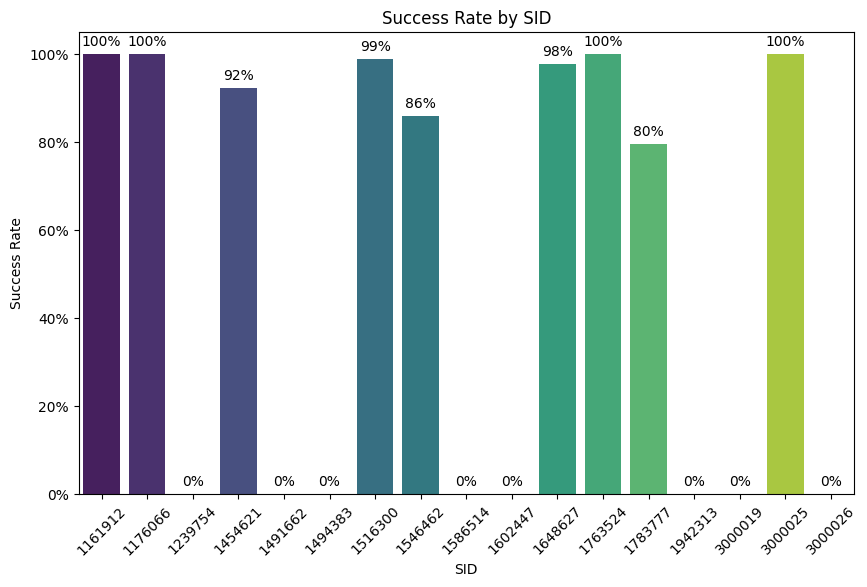

{'1161912': 1.0,
 '1176066': 1.0,
 '1239754': 0.0,
 '1454621': 0.9218045112781955,
 '1491662': 0.0,
 '1494383': 0.0,
 '1516300': 0.9887482419127989,
 '1546462': 0.8597430406852249,
 '1586514': 0.0,
 '1602447': 0.0,
 '1648627': 0.9777777777777777,
 '1763524': 1.0,
 '1783777': 0.795311845960653,
 '1942313': 0.0,
 '3000019': 0.0,
 '3000025': 1.0,
 '3000026': 0.0}

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

def draw_outcome_bar(outcome_dict, title = 'Success Rate by SID'):
    # Convert dictionary to lists for plotting
    sids = list(outcome_dict.keys())
    success_rates = list(outcome_dict.values())
    
    # Function to format y-axis as percentage
    def to_percentage(x, _):
        return f'{100 * x:.0f}%'
    
    # Bar Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=sids, y=success_rates, palette="viridis")
    plt.xlabel('SID')
    plt.ylabel('Success Rate')
    ax.yaxis.set_major_formatter(FuncFormatter(to_percentage))  # Apply percentage formatting
    plt.title(title)
    plt.xticks(rotation=45)  # Rotate labels to avoid overlap
    
    # Display the value on top of each bar
    for p in ax.patches:
        ax.annotate(to_percentage(p.get_height(), None), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')
    
    plt.show()

def drawOutcomeHistogram(outcome_dict, title = 'Distribution of Success Rates'):
    sids = list(outcome_dict.keys())
    success_rates = list(outcome_dict.values())
    # Histogram
    plt.figure(figsize=(8, 6))
    sns.histplot(success_rates, bins=10, kde=True, color='skyblue')
    plt.xlabel('Success Rate')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

def drawOutcomeScatter(outcome_dict, title = 'Success Rate Trend by SID'):
    sids = list(outcome_dict.keys())
    success_rates = list(outcome_dict.values())
    # Scatter Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=sids, y=success_rates, color='red')
    plt.xlabel('SID')
    plt.ylabel('Success Rate')
    plt.title(title)
    plt.show()
    

draw_outcome_bar(positive_sit_to_success_rate_dict)
positive_sit_to_success_rate_dict

In [46]:
prompt_generator(dfs)

In [ ]:
### Gmni
load_dotenv()
import google.generativeai as genai
system_prompt = "You are a professional Regular Expression maker."

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')
genai.configure(api_key=GEMINI_API_KEY)

model=genai.GenerativeModel(
  model_name="gemini-1.5-flash"
)
lists_of_prompts = []
list_of_responses = []
list_of_sids = []
prompt_generator([pop_df, imap_df, smtp_df, sip_df])
with open('prompt.txt', 'r') as file:
    count = 1
    paragraph = ""
    first = True
    for line in file:
        if line == '\n' and first:
            first = False
        elif first != True:
            paragraph+=line
            if line == '\n':
                count+=1
                if count == 4:
                    prompt = paragraph
                    count = 1
                    paragraph = ""
                    first = True
                    lists_of_prompts.append(prompt)
s = 0
count = 0
for prompt in lists_of_prompts:
    count+=1
    if count == 3:
        break
    for i in range (3):
        response = model.generate_content(prompt).text
        print(response)
        for r in response:
            list_of_responses.append(r)
    sid = list_of_sids[s]
    GeneratedPatternList = [
        list_of_responses[0],
        list_of_responses[1],
        list_of_responses[2],
        list_of_responses[3],
        list_of_responses[4],
        list_of_responses[5],
        list_of_responses[6],
        list_of_responses[7],
        list_of_responses[8],
    ]
    NEGATIVE_SAMPLE_NUMBER = 1000
    positive_evaluation(GeneratedPatternList, sid, sid_to_unique_texts_dict)
    negative_evaluation(GeneratedPatternList, sid, sid_to_unique_texts_dict, NEGATIVE_SAMPLE_NUMBER)
    s+=1

### OLD CODE

In [ ]:
#獲取各個SID所對應到的text
def map_sid_to_unique_texts(df):
    sid_to_texts = {}
    for _, row in df.iterrows():
        sid = row['sid']
        text = row['text']
        if pd.notnull(text):  # Ensure text is not NaN
            if sid in sid_to_texts:
                sid_to_texts[sid].add(text)
            else:
                sid_to_texts[sid] = {text}
    return sid_to_texts
sid_to_unique_texts = map_sid_to_unique_texts(pop_df)
#print(sid_to_unique_texts)

In [ ]:
#過濾掉text長度小於5的sid
def filter_sids_by_text_length(sit_to_text_dict):
    filtered_sids = set()
    for key, value in sit_to_text_dict.items():
        if len(value) > 5:  # Convert to string to avoid errors with non-string types
            filtered_sids.add(key)
    return filtered_sids

# Assuming pop_df is your DataFrame
filtered_sids = filter_sids_by_text_length(sid_to_unique_texts)
#print(filtered_sids)
#print(len(filtered_sids))

In [ ]:
def get_pcre_by_sid(sid):
    with open('sid_table(packet).csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['SID'] == str(sid):
                # Remove leading and trailing slashes from the pcre value
                print (row['pcre'])
                return row['pcre'].strip('/')
    return None

# Iterate Throush Positive payload text to see if the ans regex is correct    
def is_ans_correct(sid):
    correct = 0
    total = 0
    errorList = []
    ansPattern = get_pcre_by_sid(str(sid))
    print(f"ansPattern: {ansPattern}")
    sid_to_unique_texts = map_sid_to_unique_texts(pop_df)
    texts = sid_to_unique_texts[sid]
    for text in texts:
        total = total + 1
        correct = correct + bool(regex.search(ansPattern, text,regex.DOTALL))
        if not bool(regex.search(r'/^(GET|HEAD|POST|OPTIONS)( )(\/|\/version|\/api.*|\/jsproxy)( )(HTTP\/1\.(?:0|1))(\r\n)(.*)$/', text,regex.DOTALL)):
            errorList.append(text)

    print("answer test")
    print(f"correct: {correct}, total: {total}")
    print(len(errorList))
    for error in errorList:
        print(f"error: {error}")
    return correct, total
is_ans_correct('1783777')

{'hey': 'w'}


### ChatGPT API


In [ ]:
load_dotenv()
CHAT_GPT_API_KEY = os.getenv('C_API_KEY')
client = OpenAI(
    api_key=CHAT_GPT_API_KEY
)

completion = client.chat.completions.create(
  model="gpt-3.5-turbo-1106",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello!"}
  ]
)

print(completion.choices[0].message)


### Gemini API

In [ ]:
import google.generativeai as genai
load_dotenv()

system_prompt = "You are a cat. Your name is Neko."
user_prompt = "What is your name?"
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

genai.configure(api_key=GEMINI_API_KEY)

model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
  system_instruction=system_prompt)

response = model.generate_content(user_prompt)
print(response.text)

### Evaluation Generated Regex
Randonly take 20 positive and 20 negateve data as input to generated regex and answer regex, comparing there result.

In [ ]:
#隨機選擇除了給定的SID以外的100個text
def select_random_texts(sid_to_unique_texts, given_sid, num_texts=100):
    # Filter out the given SID
    filtered_texts = [texts for sid, texts in sid_to_unique_texts.items() if sid != given_sid]
    
    # Flatten the list of lists to a single list of texts
    all_texts = [text for sublist in filtered_texts for text in sublist]
    
    # Randomly select 100 texts, or all texts if there are fewer than 100
    selected_texts = random.sample(all_texts, min(len(all_texts), num_texts))
    
    return selected_texts

def get_pcre_by_sid(sid):
    with open('sid_table(packet).csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['SID'] == str(sid):
                # Remove leading and trailing slashes from the pcre value
                return row['pcre']
    return None

def match_patterns(targetText, GeneratedPatternList,isPositive=True):
    non_matching_patterns = []  # Step 1: Initialize list for non-matching patterns
    # Check each pattern and add non-matching ones to the list
    for i, pattern in enumerate(GeneratedPatternList):
        if not regex.search(pattern, targetText, regex.DOTALL):
            non_matching_patterns.append(f"Pattern {i+1}: {pattern}")
    ourResult = True if (9-len(non_matching_patterns)) >= 7 else False
    with open('evaluation_result.txt', 'w') as file:
        for pattern in non_matching_patterns:
            file.write(pattern)
    #ansMatch = bool(regex.search(ansPattern, targetText))
    return ourResult == isPositive

def positive_answer_evaluation(threeAnsPattern,sid):
    correct = 0
    total = 0
    errorList = []
    ansPattern = get_pcre_by_sid(str(sid))
    print(f"ansPattern: {ansPattern}")
    sid_to_unique_texts = map_sid_to_unique_texts(pop_df)
    texts = sid_to_unique_texts[sid]
    for text in texts:
        total = total + 1
        correct = correct + bool(regex.search(ansPattern, text, regex.DOTALL))
        if not match_patterns(text, threeAnsPattern, True):
            errorList.append(text)

    print("positive test")
    print(f"correct: {correct}, total: {total}")
    print(f"errorList: {errorList}")
    return correct, total
def negative_answer_evaluation(GeneratedPatternList,sid):
    correct = 0
    total = 0
    errorList = []
    ansPattern = get_pcre_by_sid(str(sid))
    texts = select_random_texts(sid_to_unique_texts, sid)
    for text in texts:
        total = total + 1
        if(not regex.search(ansPattern, text, regex.DOTALL)):
            correct = correct + 1
        if  not match_patterns(text, GeneratedPatternList, False):
            errorList.append(text)
    print("negative test")
    print(f"correct: {correct}, total: {total}")
    for error_text in errorList:
        print(error_text)
    print(f"errorList: {errorList}")
    
def positive_evaluation(threeAnsPattern,sid,file):
    correct = 0
    total = 0
    errorList = []
    ansPattern = get_pcre_by_sid(str(sid))
    print(f"ansPattern: {ansPattern}")
    sid_to_unique_texts = map_sid_to_unique_texts(pop_df)
    texts = sid_to_unique_texts[sid]
    for text in texts:
        total = total + 1
        correct = correct + match_patterns(text, threeAnsPattern, True)
        if not match_patterns(text, threeAnsPattern, True):
            errorList.append(text)

    print("positive test")
    print(f"correct: {correct}, total: {total}")
    file.write('print("positive")\n')
    for error in errorList:
        file.write('print(f"errorList: {errorList}")\n')
    return correct, total

def negative_evaluation(GeneratedPatternList,sid,file):
    correct = 0
    total = 0
    errorList = []
    ansPattern = get_pcre_by_sid(str(sid))
    texts = select_random_texts(sid_to_unique_texts, sid)
    for text in texts:
        total = total + 1
        correct = correct + match_patterns(text, GeneratedPatternList, False)
        if  not match_patterns(text, GeneratedPatternList, False):
            errorList.append(text)
    file.write('print("negative")\n')
    for error in errorList:
        file.write('print(f"errorList: {errorList}")\n')
    print(f"correct: {correct}, total: {total}")
    for error_text in errorList:
        
    
regex1 = r"/^([E|e][H|h][L|l][O|o])( [a-zA-Z0-9.-]+)?(\r\n)$/"
regex2 = r"/^EHLO( [a-zA-Z0-9.-]+)?(\r\n)$/"
regex3 = r"/^([Ee][Hh][Ll][Oo])( [a-zA-Z0-9.-]+)?(\r\n)$/"
regex4 = r"^([E|e][H|h][L|l][O|o] [a-zA-Z0-9.-]+(\.[a-zA-Z]{2,})?\r\n)$"
regex5 = r"^([E|e][H|h][L|l][O|o] [a-zA-Z0-9.-]+(\.[a-zA-Z0-9.-]+)+\r\n|[E|e][H|h][L|l][O|o]\r\n)$"
regex6 = r"^([E|e][H|h][L|l][O|o]( [a-zA-Z0-9.-]+(\.[a-zA-Z0-9.-]+)+)?\r\n)$"
regex7 = r"^(EHLO|ehlo)( [^\r\n]+)?(\r\n)$"
regex8 = r"^([E|e][H|h][L|l][O|o])( [a-zA-Z0-9.-]+)?(\r\n)$"
regex9 = r"^([Ee][Hh][Ll][Oo])( [a-zA-Z0-9.-]+)?(\r\n)$"
GeneratedPatternList = [
    regex1, regex2, regex3, regex4, regex5, regex6, regex7, regex8, regex9
]

sid = '1454621'
positive_evaluation(GeneratedPatternList, sid)
negative_evaluation(GeneratedPatternList, sid)

### Helper Function

In [ ]:
def list_csv_columns():
    with open('sid_table(packet).csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        # Print all column names
        print(reader.fieldnames)

In [ ]:
#print filtered_sids and corresponding text
for sid in filtered_sids:
    print(f"sid: {sid}, text: {sid_to_unique_texts[sid]}")

In [ ]:
protocols = [
    {'name': 'pop_df', 'data': pop_df},
    {'name': 'imap_df', 'data': imap_df},
    {'name': 'smtp_df', 'data': smtp_df},
    {'name': 'sip_df', 'data': sip_df}
]

with open('prompt.txt', 'w') as file:
    pass

with open('prompt.txt', 'a') as file:
    for protocol in protocols:
        protocol_name = protocol['name']
        protocol_data = protocol['data']
        
        sid_to_unique_texts = map_sid_to_unique_texts(protocol_data)
        filtered_sids = filter_sids_by_text_length(sid_to_unique_texts)
        
        # Sort the filtered_sids to ensure the output is ordered by SID
        sorted_filtered_sids = sorted(filtered_sids)
        
        file.write(f"Protocol: {protocol_name}\n")
        
        for sid in sorted_filtered_sids:
            texts = list(sid_to_unique_texts[sid])
            random.shuffle(texts)
            selected_texts = texts[:50]
            file.write(f"sid: {sid}, text: {selected_texts}\n")
            file.write("\n")
            file.write("Please find a regular expression to match all packet payloads.\n" + 
                       "You need to find the similarities in the sentences and generalize the parts where they differ. \n" + 
                        "The regular expression is in PCRE format, please be aware to evaluate the validity of the expression you generated under PCRE regulations. \n" + 
                        "There will be examples to help you find the patterns. \n"  +
                        "[‘DELE 3\\r\\n’, ‘DELE 128\\r\\n’, ‘DELE 74\\r\\n’, ‘DELE 22\\r\\n’, ‘DELE 70\\r\\n’] \n" +
                        "These examples show the attacker is trying to delete someone’s email by POP protocol. \n" +
                        "The index of the desired mail is indicated under the DELE command. \n" +
                        "Thus the best regular expression that matches them will be ‘^(DELE)( )(.*)(\\r\\n)$’ \n" + "\n" +
                        "With the given example payloads: \n" +
                        "[‘EHLO BtuCBHdSb51.com\\r\\n’, ‘EHLO 203.187.87.27\\r\\n’, ‘EHLO slae02Fo9Ep.com\\r\\n’, ‘EHLO 210.64.37.51\\r\\n’, ‘EHLO LLb0RwqdbkikFWo.com\\r\\n’] \n" + 
                        "These examples show the attacker is trying to make sure the SMTP server is up and running. " + 
                        "The command EHLO works in both lower case and uppercase, after that follows the SMTP server address. \n" +
                        "Thus the best regular expression to match them will be ‘^([E|e][H|h][L|l][O|o])(.*)(\\r\\n)$’ \n" + "\n" +
                        "Next, with the given payloads: \n")
            file.write(f"{selected_texts}\n")         
            file.write("Please give 3 possible and different regular expressions to match all of the elements. \n" +
                        "You can give only 1 expression if the 3 expressions you find are too similar. \n" + 
                        "Let’s work this out in a step-by-step way to make sure we have the right answer. \n" + 
                        "To make the expression not too general, make sure the expressions don’t match these negative examples: [‘CAPA\\r\\n’, ‘CAPA\\r\\n’, ‘\\x15\\x03\\x01’, ‘GET / HTTP/1.0\\r\\n\\r\\n’, ‘r\\n\\r\\n’] \n" +
                        "You only need to give me the three regular expressions in code format.\n")
            file.write("\n")
        file.write("\n")

In [ ]:
with open('all_texts.txt', 'a') as file:
    for protocol in protocols:
        protocol_name = protocol['name']
        protocol_data = protocol['data']
        
        sid_to_unique_texts = map_sid_to_unique_texts(protocol_data)
        filtered_sids = filter_sids_by_text_length(sid_to_unique_texts)
        
        file.write(f"Protocol: {protocol_name}\n")
        
        for sid in filtered_sids:
            file.write(f"sid: {sid}, text: {sid_to_unique_texts[sid]}\n")

        file.write("\n")

In [ ]:
#獲取特定資料集的所有SID
def get_unique_sids_list(df):
    unique_sids = df[df['text'].notnull()]['sid'].unique()
    return unique_sids
sidList = get_unique_sids_list(pop_df)
print(sidList)
#print(len(sidList))